In [1]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# This generates the whole hamiltonian for the tunnelling double well

def generate_hamiltonians(a_values, b_values):
    """
    Generate and store Hamiltonians of the form:
        H = (1/2) * a * σ_z + (1/2) * b * σ_x

    Parameters
    ----------
    a_values : list or np.ndarray
        List of 'a' coefficients (energy asymmetry terms).
    b_values : list or np.ndarray
        List of 'b' coefficients (tunneling amplitude terms).

    Returns
    -------
    hamiltonians : dict
        Dictionary with keys as (a, b) tuples and values as corresponding Qobj Hamiltonians.
    """

    # Define Pauli matrices
    sigma_z = qt.sigmaz()
    sigma_x = qt.sigmax()


    hamiltonians = {}

    for a in a_values:
        for b in b_values:
            H = 0.5 * a * sigma_z + 0.5 * b * sigma_x
            hamiltonians[(a, b)] = H
    return hamiltonians


In [3]:
a_vals = np.linspace(-2, 2, 5)
b_vals = np.linspace(-1, 1, 5)
hams = generate_hamiltonians(a_vals, b_vals)

In [4]:
H = hams[(-2.0, -1.0)]

In [5]:
H.eigenstates()

(array([-1.11803399,  1.11803399]),
 array([Quantum object: dims=[[2], [1]], shape=(2, 1), type='ket', dtype=Dense
        Qobj data =
        [[-0.97324899]
         [-0.22975292]]                                                       ,
        Quantum object: dims=[[2], [1]], shape=(2, 1), type='ket', dtype=Dense
        Qobj data =
        [[-0.22975292]
         [ 0.97324899]]                                                       ],
       dtype=object))

In [6]:
# Display eigenvals and corr eigenvec

eigenvals, eigenstates = H.eigenstates(sort='low')
for i, (E, psi) in enumerate(zip(eigenvals, eigenstates)):
    print(f"Eigenvalue {i+1}: {E:.4f}")
    print(f"Eigenstate {i+1}:")
    print(psi)
    print("-"*40)

Eigenvalue 1: -1.1180
Eigenstate 1:
Quantum object: dims=[[2], [1]], shape=(2, 1), type='ket', dtype=Dense
Qobj data =
[[-0.97324899]
 [-0.22975292]]
----------------------------------------
Eigenvalue 2: 1.1180
Eigenstate 2:
Quantum object: dims=[[2], [1]], shape=(2, 1), type='ket', dtype=Dense
Qobj data =
[[-0.22975292]
 [ 0.97324899]]
----------------------------------------


In [7]:
# Evolve the ground states according to Hamiltonians 

def time_evolve_ground_state(hamiltonians, state, tlist=None, save_dir="evolutions"):
    """
    Time-evolve the ground state of one Hamiltonian under all Hamiltonians in the given dictionary.

    Parameters
    ----------
    hamiltonians : dict
        Dictionary {(a, b): Qobj Hamiltonian}.
    tlist : array-like, optional
        List of time points to evolve over (default: np.linspace(0, 10, 200)).
    save_dir : str, optional
        Directory where evolved states will be stored.

    Returns
    -------
    evolutions : dict
        Dictionary {(a, b): [Qobj(t_0), Qobj(t_1), ...]} for each Hamiltonian.
    """

    if tlist is None:
        tlist = np.linspace(0, 10, 200)

    # Pick the first Hamiltonian 
    # print(list(hamiltonians.keys()))
    
    ref_key = list(hamiltonians.keys())[0]
    H_ref = hamiltonians[ref_key]
    
    
    # Find the ground states 
    # E_vals, E_states = H_ref.eigenstates(sort='low')
    psi0 = state # Ground state

    # print(f"Reference Hamiltonian: {ref_key}")
    # print(f"Ground state energy: {E_vals[0]:.4f}\n")

    # Dictionary to store results
    evolutions = {}

    for key, H in hamiltonians.items():
        result = qt.sesolve(H, psi0, tlist)
        evolutions[key] = result.states

        # Save to pickle
        # filename = f"evolution_a{key[0]:.3f}_b{key[1]:.3f}.pkl"
        # filepath = os.path.join(save_dir, filename)
        # with open(filepath, "wb") as f:
        #     pickle.dump(result, f)

        # print(f"Evolved under H(a={key[0]:.2f}, b={key[1]:.2f}) → saved to {filename}")

    return evolutions

In [8]:
# All the previous stuuff again

a_vals = np.linspace(-2, 2, 5)
b_vals = np.linspace(-1, 1, 5)
hams = generate_hamiltonians(a_vals, b_vals)

# Time indices
tlist = np.linspace(0, 5, 100)

# First Hamiltonian
H = hams[(-2.0, -1.0)]
H.eigenstates()
eigenvals, eigenstates = H.eigenstates(sort='low')

# Evolve the ground state
evolutions = time_evolve_ground_state(hamiltonians=hams, state=eigenstates[0], tlist=tlist)

In [9]:
# Extract the first excited state from the reference Hamiltonian
excited_state = eigenstates[1]
key = (-2.0, -1.0) # Key for which Hamiltonian
states_t = evolutions[key]


# Fidelities from qutip lib 
fidelities = [qt.fidelity(excited_state, psi_t)**2 for psi_t in states_t]

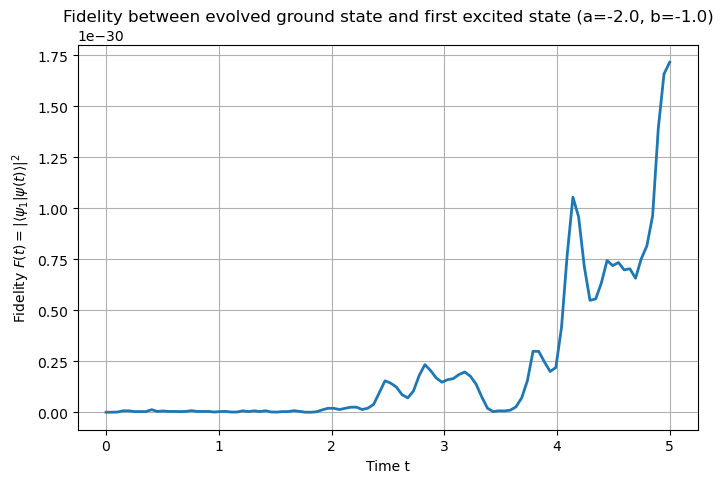

In [10]:
plt.figure(figsize=(8,5))
plt.plot(tlist, fidelities, lw=2)
plt.xlabel("Time t")
plt.ylabel(r"Fidelity $F(t) = |\langle \psi_1 | \psi(t) \rangle|^2$")
plt.title(f"Fidelity between evolved ground state and first excited state (a={key[0]}, b={key[1]})")
plt.grid(True)
plt.show()

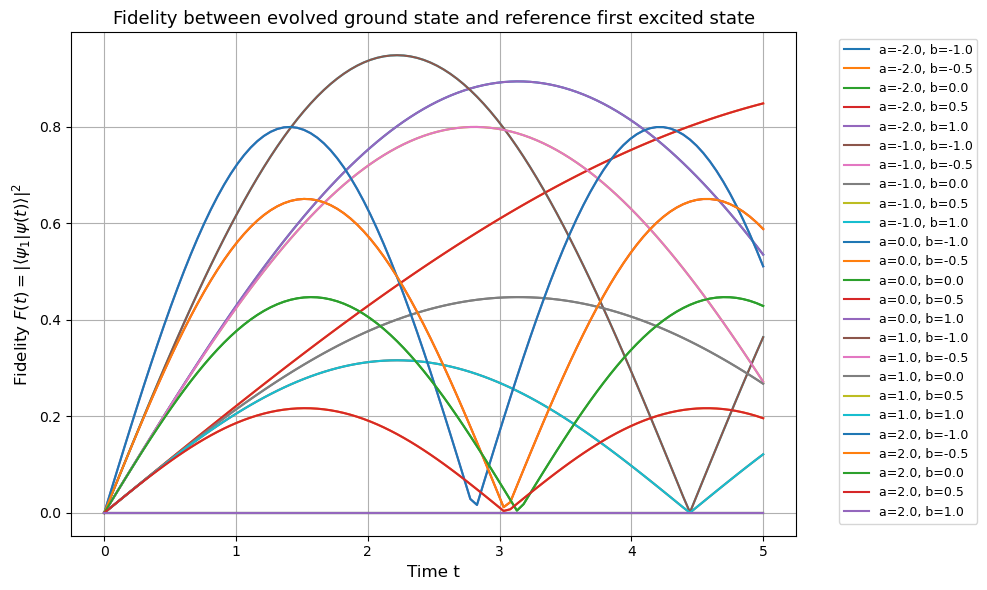

In [11]:
plt.figure(figsize=(10, 6))

for key, states_t in evolutions.items():
    fidelities = [qt.fidelity(excited_state, psi_t) for psi_t in states_t]
    plt.plot(tlist, fidelities, label=f"a={key[0]}, b={key[1]}")

plt.xlabel("Time t", fontsize=12)
plt.ylabel(r"Fidelity $F(t) = |\langle \psi_1 | \psi(t) \rangle|^2$", fontsize=12)
plt.title("Fidelity between evolved ground state and reference first excited state", fontsize=13)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.grid(True)
plt.tight_layout()
plt.show()

# Experimental evidence that Unitary evolution does nothing of significance to homochirality
# Only Linbladians can solve this


## Superpositions

In [12]:
H0_key = (-2.0, -1.0)
H0 = hams[H0_key]

In [13]:
# eigenbasis of H0
evals0, evecs0 = H0.eigenstates(sort='low')
g0, e0 = evecs0[0], evecs0[1]

In [14]:
# --- define the superposition in the H0 eigenbasis ---
theta = np.pi/4   # 45-45 superposition; change if you like
phi   = 0.0       # relative phase
psi0 = np.cos(theta)*g0 + np.exp(1j*phi)*np.sin(theta)*e0

In [15]:
# --- evolve under all Hamiltonians ---
def evolve_state_under_all(hamiltonians, psi_init, tlist):
    evol = {}
    for key, H in hamiltonians.items():
        res = qt.sesolve(H, psi_init, tlist)
        evol[key] = res.states
    return evol

In [16]:
tlist = np.linspace(0, 5, 400)  # finer grid to see oscillations clearly
evol_all = evolve_state_under_all(hams, psi0, tlist)

In [20]:
# --- helpers to compute quantities in the H0 (g0,e0) basis ---
def Pg_Pe_series(states, g_ref, e_ref):
    Pg = np.array([abs(g_ref.overlap(psi))**2 for psi in states])
    Pe = np.array([abs(e_ref.overlap(psi))**2 for psi in states])
    return Pg, Pe

In [23]:
def fidelity_series(states, psi_ref):
    return np.array([abs(psi_ref.overlap(psi))**2 for psi in states])

In [24]:
# --- compute and check stationarity under H0 ---
Pg0, Pe0 = Pg_Pe_series(evol_all[H0_key], g0, e0)
F0 = fidelity_series(evol_all[H0_key], psi0)

In [25]:
# numeric checks (tolerances are modest; adjust if needed)
def is_flat(x, rtol=1e-3, atol=1e-4):
    # compare variance to scale of series
    return np.var(x) <= max(atol, rtol*np.max(x)**2)

print("Under H0:")
print(f"  Pg(t) ~ constant at ~{Pg0.mean():.6f}?  -> {'YES' if is_flat(Pg0) else 'NO'}")
print(f"  Pe(t) ~ constant at ~{Pe0.mean():.6f}?  -> {'YES' if is_flat(Pe0) else 'NO'}")
print(f"  Fidelity F(t)=|<ψ0|ψ(t)>|^2 flat?       -> {'YES' if is_flat(F0) else 'NO'} (expected NO unless pure eigenstate)")


Under H0:
  Pg(t) ~ constant at ~0.500000?  -> YES
  Pe(t) ~ constant at ~0.500000?  -> YES
  Fidelity F(t)=|<ψ0|ψ(t)>|^2 flat?       -> NO (expected NO unless pure eigenstate)


In [26]:
# --- check a few non-reference Hamiltonians for oscillations in H0 basis ---
varying = []
for key, states in evol_all.items():
    if key == H0_key:
        continue
    Pg, Pe = Pg_Pe_series(states, g0, e0)
    if (not is_flat(Pg)) or (not is_flat(Pe)):
        varying.append(key)
        

In [27]:
print(varying[:10], "... (showing up to 10)")

[(np.float64(-2.0), np.float64(-0.5)), (np.float64(-2.0), np.float64(0.0)), (np.float64(-2.0), np.float64(0.5)), (np.float64(-2.0), np.float64(1.0)), (np.float64(-1.0), np.float64(-1.0)), (np.float64(-1.0), np.float64(0.0)), (np.float64(-1.0), np.float64(0.5)), (np.float64(-1.0), np.float64(1.0)), (np.float64(0.0), np.float64(-1.0)), (np.float64(0.0), np.float64(-0.5))] ... (showing up to 10)


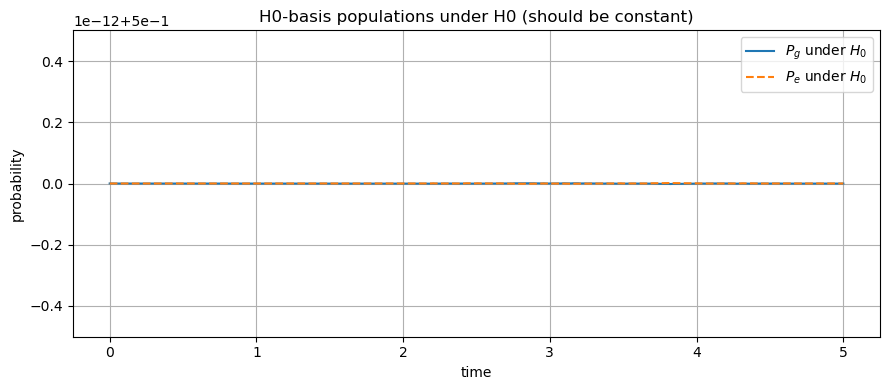

In [28]:
# --- plotting ---
plt.figure(figsize=(9,4))
plt.plot(tlist, Pg0, label=r"$P_g$ under $H_0$")
plt.plot(tlist, Pe0, label=r"$P_e$ under $H_0$", linestyle="--")
plt.title("H0-basis populations under H0 (should be constant)")
plt.xlabel("time")
plt.ylabel("probability")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

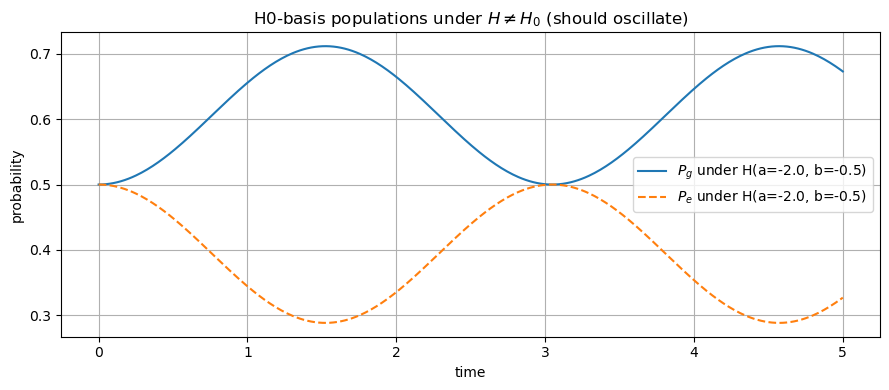

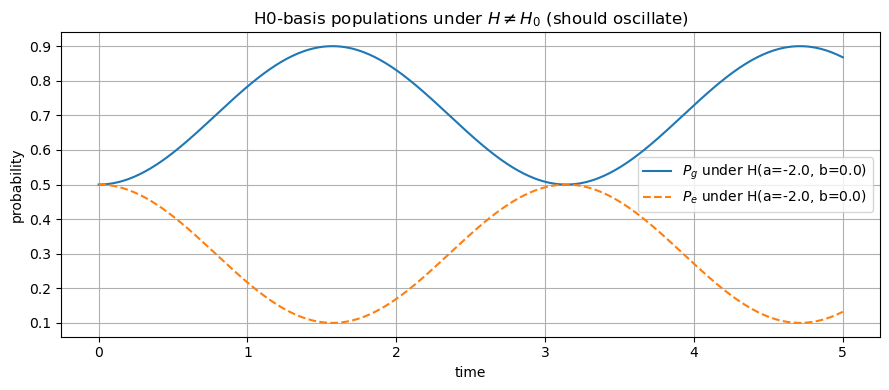

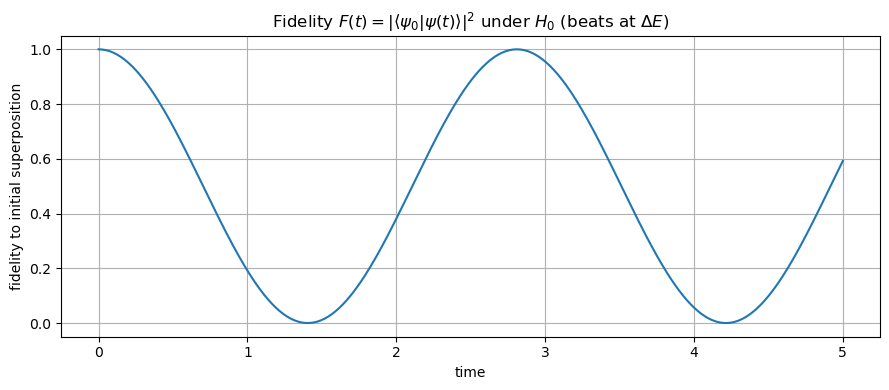

In [30]:
# pick two contrasting non-reference Hamiltonians to visualize
others_to_plot = []
for key in hams.keys():
    if key != H0_key:
        others_to_plot.append(key)
    if len(others_to_plot) == 2:
        break

for key in others_to_plot:
    Pg, Pe = Pg_Pe_series(evol_all[key], g0, e0)
    plt.figure(figsize=(9,4))
    plt.plot(tlist, Pg, label=rf"$P_g$ under H(a={key[0]}, b={key[1]})")
    plt.plot(tlist, Pe, label=rf"$P_e$ under H(a={key[0]}, b={key[1]})", linestyle="--")
    plt.title(r"H0-basis populations under $H\neq H_0$ (should oscillate)")
    plt.xlabel("time")
    plt.ylabel("probability")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Also show that fidelity to the initial superposition is not constant even under H0
plt.figure(figsize=(9,4))
plt.plot(tlist, F0)
plt.title(r"Fidelity $F(t)=|\langle\psi_0|\psi(t)\rangle|^2$ under $H_0$ (beats at $\Delta E$)")
plt.xlabel("time")
plt.ylabel("fidelity to initial superposition")
plt.grid(True)
plt.tight_layout()
plt.show()

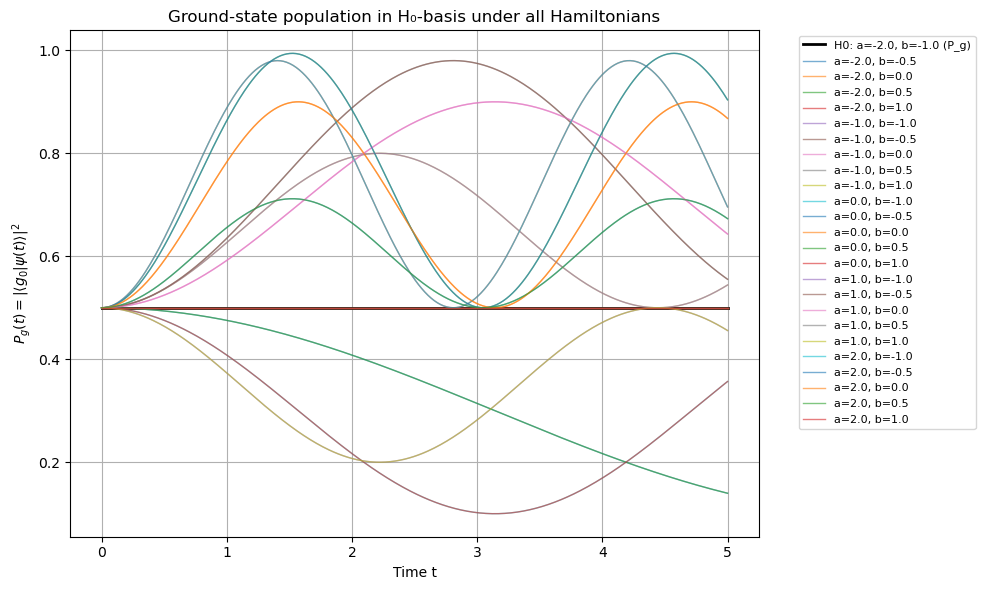

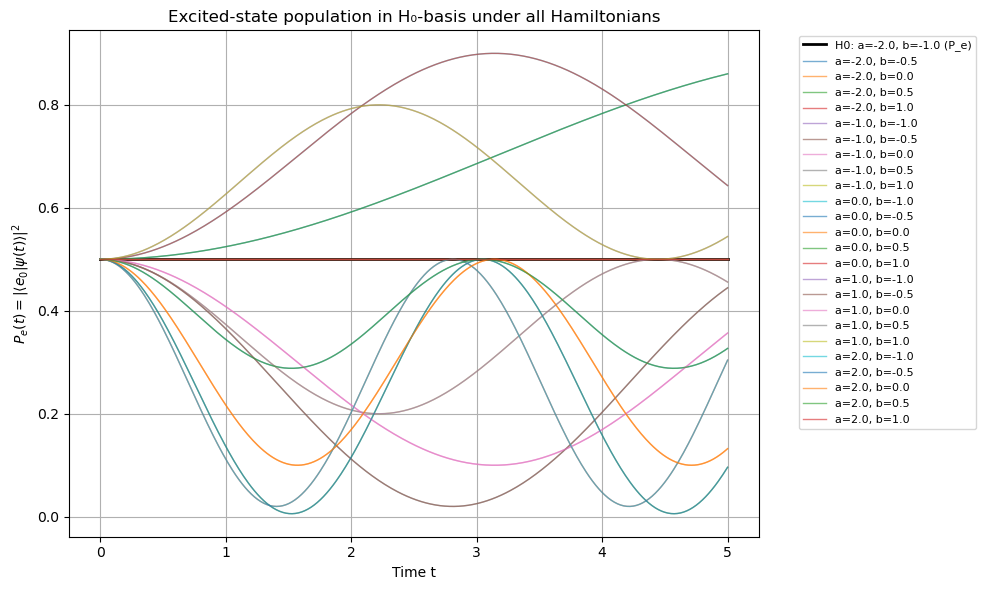

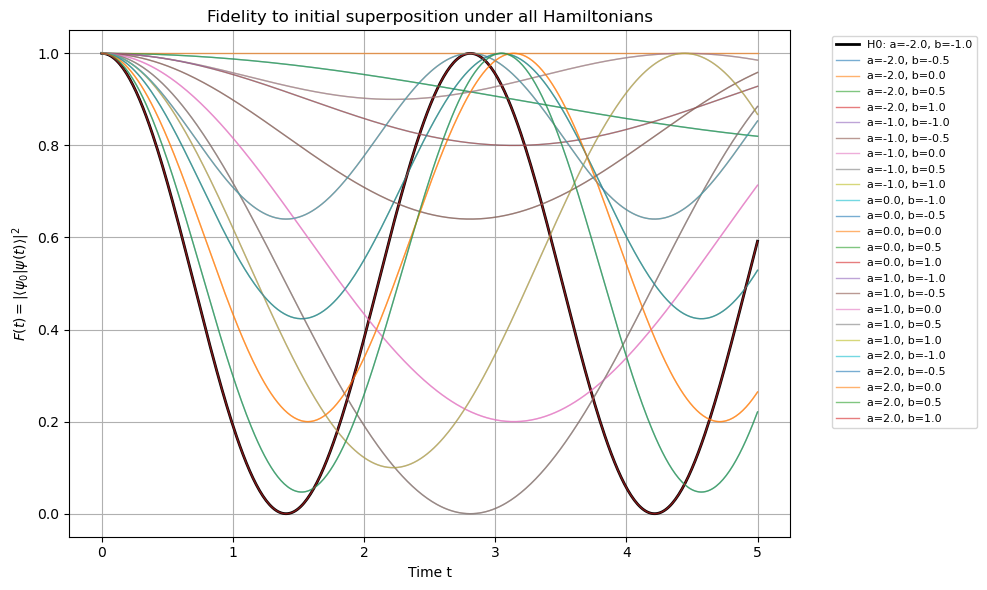

In [31]:
plt.figure(figsize=(10,6))
for key, states in evol_all.items():
    Pg, Pe = Pg_Pe_series(states, g0, e0)
    if key == H0_key:
        plt.plot(tlist, Pg, color='black', lw=2, label=f"H0: a={key[0]}, b={key[1]} (P_g)")
    else:
        plt.plot(tlist, Pg, lw=1, alpha=0.6, label=f"a={key[0]}, b={key[1]}")

plt.xlabel("Time t")
plt.ylabel(r"$P_g(t) = |\langle g_0|\psi(t)\rangle|^2$")
plt.title("Ground-state population in H₀-basis under all Hamiltonians")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()

# --- excited-state populations ---
plt.figure(figsize=(10,6))
for key, states in evol_all.items():
    Pg, Pe = Pg_Pe_series(states, g0, e0)
    if key == H0_key:
        plt.plot(tlist, Pe, color='black', lw=2, label=f"H0: a={key[0]}, b={key[1]} (P_e)")
    else:
        plt.plot(tlist, Pe, lw=1, alpha=0.6, label=f"a={key[0]}, b={key[1]}")

plt.xlabel("Time t")
plt.ylabel(r"$P_e(t) = |\langle e_0|\psi(t)\rangle|^2$")
plt.title("Excited-state population in H₀-basis under all Hamiltonians")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()

# --- fidelity to the initial superposition for each H ---
plt.figure(figsize=(10,6))
for key, states in evol_all.items():
    F = fidelity_series(states, psi0)
    if key == H0_key:
        plt.plot(tlist, F, color='black', lw=2, label=f"H0: a={key[0]}, b={key[1]}")
    else:
        plt.plot(tlist, F, lw=1, alpha=0.6, label=f"a={key[0]}, b={key[1]}")

plt.xlabel("Time t")
plt.ylabel(r"$F(t) = |\langle \psi_0|\psi(t)\rangle|^2$")
plt.title("Fidelity to initial superposition under all Hamiltonians")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()